# ATE estimations from generated observational data
*This notebook examines the use of Bayesian Networks for estimating Average Treatment Effects (ATE) in Observational Studies within the Neyman-Rubin potential outcome framework from generated data:* [Lunceford & Davidian (2004)]("https://pubmed.ncbi.nlm.nih.gov/15351954/")

### Context

In contrast to randomized controlled trials (RCTs) where the ignorability assumption is satisfied, estimating treatment effects from observational data introduces new complexities.

Under RCT conditions, an unbiased estimator of the Average Treatment Effect (ATE) can be effectively computed by comparing the means of the observed treated subjects and the observed untreated subjects.
However, in observational data, the ignorability assumption often does not hold, as subjects with certain treatment outcomes may be more or less likely to receive the treatment (i.e. $ \mathbb{E}[Y(t)|T=t] \neq \mathbb{E}[Y(t)], \ t \in \{0,1\}$). Consequently, previous estmation methods are not guaranteed to be unbiased. 

Nevertheless, if we can identify the confounders that *d-separates* the potential outcomes from the treatement assignment, we can achieve conditional independence between the treatment and the outcomes by conditionning on the confounders. Suppose that the covariate vector contains all such confounders, then:

$$\begin{align*}
T \perp \!\!\! \perp \{ Y(0), Y(1)\} \mid X & \quad \mathrm{(Unconfoundedness)}
\end{align*}$$

This conditional independence allows for estimations of the ATE from observational data. 

In [88]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, logistic

### Generated Data

* The *outcome* variable $Y$ is generated according the following equation:
$$ \begin{align*} 
Y & = - X_1 + X_2 - X_3 +2 T -V_1 + V_2 + V_3 \\
  & = \langle \nu , \boldsymbol{Z} \rangle + \langle \xi, \boldsymbol{V} \rangle
\end{align*}$$

Where $\nu = (0, -1, 1, -1, 2)^\intercal$, $\boldsymbol{Z} = (1, X_1, X_2, X_3, T)^\intercal$, $\xi = (-1,1,1)^\intercal$ and $\boldsymbol{V} = (V_1, V_2, V_3)^\intercal$. 

* The *covariates* are distributed as $X_3 \sim \text{Bernoulli}\left(0.2\right)$. Conditionally $X_3$, the distribution of the other variables is defined as:

If $X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{0}, \Sigma)$ 

If $ X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right) \ \text{and} \ \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

* The *treatment* $T$ is generated as a Bernoulli of the *propensity score*:
$$ \begin{align*}
\mathbb{P}[T=1|X] &= e\left(X, \beta\right) \\
&= (1+\exp (-0.6 X_{1} +0.6 X_{2} - 0.6 X_{3}))^{-1} \\
&= \frac{1}{1+e^{-\langle \beta , \boldsymbol{X} \rangle}} \\
\mathbb{P}[T=0|X] &= 1-\mathbb{P}[T=1|X]
\end{align*}$$
With $\beta = {\left(0, 0.6, -0.6, 0.6\right)}^{\intercal}$ and $\boldsymbol{X} = (1, X_1, X_2, X_3)^{\intercal}$.

In [89]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

Here, the exact ATE can be explicitly calculated using the previously defined assumptions.

$$ \begin{align*}
\mathbb{E}[Y(1) - Y(0)] &= \mathbb{E} [ (- X_1 + X_2 - X_3 + 2 \times 1 -V_1 + V_2 + V_3) - (- X_1 + X_2 - X_3 + 2 \times 0 -V_1 + V_2 + V_3 ) ] \\
&= 2
\end{align*} $$

In [90]:
df = generate_lunceford(int(1e6))
df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,0.464229,-0.430723,0,1,0.099841,-1.011027,0,0.075322
1,-1.150273,-0.266724,0,0,-2.428685,0.263078,0,4.929957
2,-1.468083,2.036699,0,1,-0.352060,1.520255,1,8.581494
3,-0.466710,0.906196,0,1,-1.431502,0.897375,1,5.796999
4,0.555739,-0.323768,1,0,1.226500,-0.554684,1,-4.098917


### 1 - "Exact" Computation

In [91]:
# Declarations of functions used in this section

def getBN(# Covariate parameters
          covariate_start : int = -5.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          # Outcome parameters
          outcome_start = -10.0 ,
          outcome_end = 15.0 ,
          outcome_num_split = 60,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True,
          fill_distribution : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        plus = "" if fill_distribution else "+"
        bn = gum.BayesNet()
        for i in range(1,3):
            bn.add(f"X{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
            bn.add(f"V{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add(f"X3[2]")
        bn.add(f"V3[2]")
        bn.add("T[2]")
        bn.add(f"Y{plus}[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        for X in ["X1", "X2", "X3"]:
            bn.addArc(X, "T")
        for XV in ["X1", "V1", "X2", "V2"]:
            bn.addArc("X3", XV)
        bn.addArc("X3", "V3")
        bn.endTopologyTransformation()

    if add_arcs and fill_distribution:
        bn.cpt("X3").fillWith([0.8, 0.2])
        bn.cpt("V3")[:] = [[0.75, 0.25], [0.25, 0.75]]
        for XV in ["X", "V"]:
            bn.cpt(f"{XV}1").fillFromDistribution(norm, loc="2*X3-1", scale=1)
            bn.cpt(f"{XV}2").fillFromDistribution(norm, loc="1-2*X3", scale=1)
        bn.cpt("T").fillFromDistribution(logistic, loc="-0.6*X1+0.6*X2-0.6*X3", scale=1)
        bn.cpt("Y").fillFromDistribution(norm, loc="-X1+X2-X3+2*T-V1+V2+V3", scale=1)

    return bn

def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents("T"):
        res.eraseArc(p_id, bn.idFromName("T"))
    return res

def ATE(bn : gum.BayesNet) -> float:
    """
    Returns estimation of the ATE directly from Baysian Network.
    """

    ie = gum.LazyPropagation(mutilateBN(bn))

    ie.setEvidence({"T": 0})
    ie.makeInference()
    p0 = ie.posterior("Y")

    ie.chgEvidence("T",1)
    ie.makeInference()
    p1 = ie.posterior("Y")

    dif = p1 - p0
    return dif.expectedValue(lambda d: dif.variable(0).numerical(d[dif.variable(0).name()]))

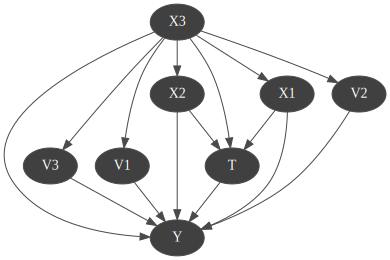

In [92]:
exbn = getBN(covariate_num_split=5, outcome_num_split=100)
gnb.showBN(exbn, size="50")

In [93]:
gnb.sideBySide(gnb.getInference(mutilateBN(exbn), evs={"T":0}, targets={"Y"}),
               gnb.getInference(mutilateBN(exbn), evs={"T":1}, targets={"Y"}),
               captions=["T=0", "T=1"])

print(exbn)
print(f"{ATE(exbn) = }")

BN{nodes: 8, arcs: 15, domainSize: 500000, dim: 495085, mem: 3Mo 835Ko 400o}
ATE(exbn) = 1.9974318302904037


Varying the granularity of the discretization of covariates and the outcome variable yields different results in ATE estimation. For exact computations, the degree of discretization has minimal impact on the final result, as the expression of the outcome distribution is directly incorporated into the variable. However, in the case of learning estimators, a coarser discretization may hinder the model's ability to capture the intricacies of the outcome distribution, while an excessively fine discretization can introduce an excessive number of parameters to be learned from the data. Consequently, the quality of the estimation is sensitive to the discretization settings. Therefore, selecting the appropriate level of discretization is crucial for the accuracy of the estimators. 

For the proposed model, we observe that a 10-bin discretization for the covariates and an 80-bin discretization for the outcome yield superior results.

In [156]:
covariate_split_list = range(3,10,1)
outcome_split_list = [50]#]range(50,351,100)

e_grid = np.zeros((len(covariate_split_list), len(outcome_split_list)))

for i in range(len(covariate_split_list)):
    for j in range(len(outcome_split_list)):
        bn = getBN(covariate_num_split=covariate_split_list[i],
                   outcome_num_split=outcome_split_list[j])
        ate = ATE(bn)
        e_grid[i][j] = ate

        print(f"{covariate_split_list[i] = }, "\
              f"{outcome_split_list[j] = }, " \
              f"{ate = }")

covariate_split_list[i] = 3, outcome_split_list[j] = 50, ate = 1.9991830085861
covariate_split_list[i] = 4, outcome_split_list[j] = 50, ate = 1.9989566899513704
covariate_split_list[i] = 5, outcome_split_list[j] = 50, ate = 1.9974432482262623
covariate_split_list[i] = 6, outcome_split_list[j] = 50, ate = 1.9978207054750636
covariate_split_list[i] = 7, outcome_split_list[j] = 50, ate = 1.9978323873990393
covariate_split_list[i] = 8, outcome_split_list[j] = 50, ate = 1.9978290354405743
covariate_split_list[i] = 9, outcome_split_list[j] = 50, ate = 1.9978300616131652


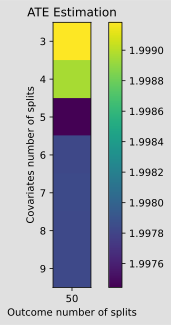

In [157]:
plt.imshow(e_grid)
plt.yticks(np.arange(len(covariate_split_list)), labels=covariate_split_list)
plt.xticks(np.arange(len(outcome_split_list)), labels=outcome_split_list)
plt.colorbar()
plt.xlabel("Outcome number of splits")
plt.ylabel("Covariates number of splits")
plt.title("ATE Estimation")

plt.show()

### 2 - Parameter Learning

We will first evaluate the results of the parameter learning algorithm using a Bayesian network where the variable domains come from the generated data. Here, we used `skbn.BNDiscretizer` with uniform discretization.

In [96]:
discretized_p_template = getBN(data=df, covariate_num_split=3, outcome_num_split=80)

In [97]:
disc_p_learner = gum.BNLearner(df, discretized_p_template)
disc_p_learner.useNMLCorrection()
disc_p_learner.useSmoothingPrior(1e-9)

disc_plbn = gum.BayesNet(discretized_p_template)
disc_p_learner.fitParameters(disc_plbn)

print(disc_p_learner)

Filename       : /tmp/tmpdw73qi56.csv
Size           : (1000000,8)
Variables      : X1[3], X2[3], X3[2], T[2], V1[3], V2[3], V3[2], Y[80]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [98]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_plbn), evs={"T":0}, targets={"Y"}),
               gnb.getInference(mutilateBN(disc_plbn), evs={"T":1}, targets={"Y"}),
               captions=["T=0", "T=1"])

print(disc_plbn)
print(f"{ATE(disc_plbn) = }")

BN{nodes: 8, arcs: 15, domainSize: 51840, dim: 51229, mem: 405Ko 528o}
ATE(disc_plbn) = 1.2043430028053494


The estimated ATE is slightly less than the expected ATE of 2.

Next, we will evaluate the performance of the parameter learning algorithm when provided the same custom template as the exact Baysian Network. 

In [99]:
custom_p_template = getBN(fill_distribution=False, covariate_num_split=9, outcome_num_split=80)

In [100]:
cstm_p_learner = gum.BNLearner(df, custom_p_template)
cstm_p_learner.useNMLCorrection()
cstm_p_learner.useSmoothingPrior(1e-9)

cstm_plbn = gum.BayesNet(custom_p_template)
cstm_p_learner.fitParameters(cstm_plbn)

print(cstm_p_learner)

Filename       : /tmp/tmpoqn0jrf7.csv
Size           : (1000000,8)
Variables      : X1[9], V1[9], X2[9], V2[9], X3[2], V3[2], T[2], Y[80]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [101]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_plbn), evs={"T":0}, targets={"Y"}),
               gnb.getInference(mutilateBN(cstm_plbn), evs={"T":1}, targets={"Y"}),
               captions=["T=0", "T=1"])

print(cstm_plbn)
print(f"{ATE(cstm_plbn) = }")

BN{nodes: 8, arcs: 15, domainSize: 10^6.62315, dim: 4146781, mem: 32Mo 40Ko 144o}
ATE(cstm_plbn) = 1.7516956535880326


The estimated ATE is similar to the previously obtained one when using the discretized template. However, given that this approach is computationally much faster, we will use it to plot the estimated ATE's evolution as the number of observations increases.

In [102]:
p_template = custom_p_template

num_obs_list = [5e4, 1e5, 2e5, 4e5]
num_shots = 10
pl_tau_hat_arr = list()

for i in num_obs_list:
    pl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        p_learner = gum.BNLearner(df, p_template)
        p_learner.useNMLCorrection()
        p_learner.useSmoothingPrior(1e-9)

        plbn = gum.BayesNet(p_template)
        p_learner.fitParameters(plbn)

        pl_tau_hat_arr[-1].append(ATE(plbn))

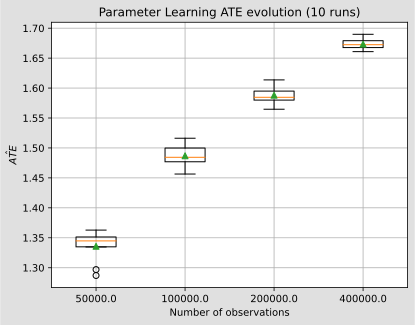

In [103]:
plt.boxplot(pl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
#plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"Parameter Learning ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.grid(True)
plt.show()

In [152]:
covariate_split_list = range(3,10,1)
outcome_split_list = [50]#range(50,351,100)

ratio = 0.2

p_grid = np.zeros((len(covariate_split_list), len(outcome_split_list)))

for i in range(len(covariate_split_list)):
    for j in range(len(outcome_split_list)):
        template = getBN(data=df, fill_distribution=False,
                         covariate_num_split=covariate_split_list[i],
                         outcome_num_split=outcome_split_list[j])
        exbn = getBN(data=df,
                     covariate_num_split=covariate_split_list[i],
                     outcome_num_split=outcome_split_list[j])

        p_learner = gum.BNLearner(df, template)
        p_learner.useNMLCorrection()

        #p_learner.useSmoothingPrior(1e-9)
        p_learner.useDirichletPrior(exbn)

        bn = gum.BayesNet(template)
        p_learner.fitParameters(bn)

        ate = ATE(bn)
        p_grid[i][j] = ate

        print(f"{covariate_split_list[i] = }, "\
              f"{outcome_split_list[j] = }, " \
              f"{ate = }")

p_grid[p_grid == 0.0] = None

covariate_split_list[i] = 3, outcome_split_list[j] = 50, ate = 1.2918401890554192
covariate_split_list[i] = 4, outcome_split_list[j] = 50, ate = 1.4588767231752726
covariate_split_list[i] = 5, outcome_split_list[j] = 50, ate = 1.6987106056623782
covariate_split_list[i] = 6, outcome_split_list[j] = 50, ate = 1.7555896282337795
covariate_split_list[i] = 7, outcome_split_list[j] = 50, ate = 1.8226358899825488
covariate_split_list[i] = 8, outcome_split_list[j] = 50, ate = 1.8595935481464314
covariate_split_list[i] = 9, outcome_split_list[j] = 50, ate = 1.890309486308385


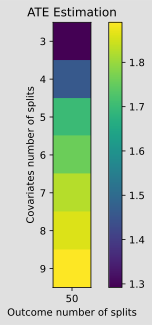

In [153]:
plt.imshow(p_grid)
plt.yticks(np.arange(len(covariate_split_list)), labels=covariate_split_list)
plt.xticks(np.arange(len(outcome_split_list)), labels=outcome_split_list)
plt.colorbar()
plt.xlabel("Outcome number of splits")
plt.ylabel("Covariates number of splits")
plt.title("ATE Estimation")

plt.show()

### 3 - Structure Learning

As before, structure learning can be performed on discretized variables derived from the data or by specifying the variables to be used in the process. Here, we observed that a 5-bins discretisation for the covariates and the outcome yielded the best results. 

In [134]:
discretized_s_template = getBN(data=df, add_arcs=False, covariate_num_split=5, outcome_num_split=5)

In [135]:
disc_s_learner = gum.BNLearner(df, discretized_s_template)
disc_s_learner.useNMLCorrection()
disc_s_learner.useSmoothingPrior(1e-6)
disc_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
disc_slbn = disc_s_learner.learnBN()

print(disc_s_learner)

Filename               : /tmp/tmpnopl88mr.csv
Size                   : (400000,8)
Variables              : X1[5], X2[5], X3[2], T[2], V1[5], V2[5], V3[2], Y[5]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {T:2, X2:1, V3:1, V1:1, Y:3, X3:0, X1:1, V2:1}



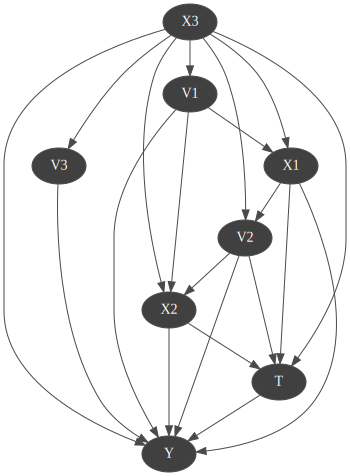

In [136]:
gnb.showBN(disc_slbn, size="50")

In [137]:
gnb.sideBySide(gnb.getInference(mutilateBN(disc_slbn), evs={"T":0}, targets={"Y"}),
               gnb.getInference(mutilateBN(disc_slbn), evs={"T":1}, targets={"Y"}),
               captions=["T=0", "T=1"])

print(disc_slbn)
print(f"{ATE(disc_slbn) = }")

BN{nodes: 8, arcs: 20, domainSize: 25000, dim: 20541, mem: 202Ko 80o}
ATE(disc_slbn) = 1.7769010786979305


The structure learning algorithm using discretized variables performs slightly worse than the parameter learning algorithm, as evidenced by the greater bias of the ATE. 

In [138]:
custom_s_template = getBN(fill_distribution=False, add_arcs=False, covariate_num_split=5, outcome_num_split=5)

In [139]:
cstm_s_learner = gum.BNLearner(df, custom_s_template)
cstm_s_learner.useNMLCorrection()
cstm_s_learner.useSmoothingPrior(1e-6)
cstm_s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
cstm_slbn = cstm_s_learner.learnBN()

print(cstm_s_learner)

Filename               : /tmp/tmp7ygyx19j.csv
Size                   : (400000,8)
Variables              : X1[5], V1[5], X2[5], V2[5], X3[2], V3[2], T[2], Y[5]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {V2:1, V1:1, T:2, X3:0, Y:3, X1:1, X2:1, V3:1}



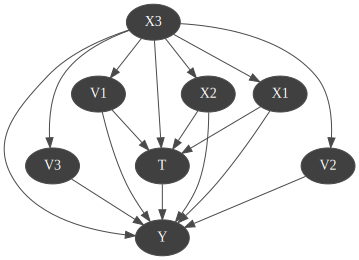

In [140]:
gnb.showBN(cstm_slbn, size="50")

In [141]:
gnb.sideBySide(gnb.getInference(mutilateBN(cstm_slbn), evs={"T":0}, targets={"Y"}),
               gnb.getInference(mutilateBN(cstm_slbn), evs={"T":1}, targets={"Y"}),
               captions=["T=0", "T=1"])

print(cstm_slbn)
print(f"{ATE(cstm_slbn) = }")

BN{nodes: 8, arcs: 16, domainSize: 25000, dim: 20285, mem: 199Ko 592o}
ATE(cstm_slbn) = 1.6897338052619848


Again, let's evaluate the evolution of the estimated ATE. 

In [142]:
template = custom_s_template

num_obs_list = [5e4, 1e5, 2e5, 4e5]
num_shots = 10
sl_tau_hat_arr = list()

for i in num_obs_list:
    sl_tau_hat_arr.append(list())
    for j in range(num_shots):
        df = generate_lunceford(int(i))

        s_learner = gum.BNLearner(df, template)
        s_learner.useNMLCorrection()
        s_learner.useSmoothingPrior(1e-6)
        s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
        slbn = s_learner.learnBN()

        sl_tau_hat_arr[-1].append(ATE(slbn))

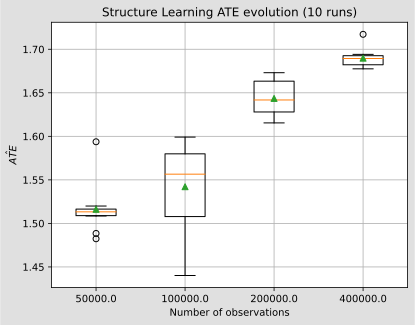

In [143]:
plt.boxplot(sl_tau_hat_arr, labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
#plt.axhline(y=2, color='r', linestyle='--', linewidth=1)
plt.title(f"Structure Learning ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")
plt.grid(True)
plt.show()

In [144]:
covariate_split_list = range(3,10,1)
outcome_split_list = range(50,601,50)

s_grid = np.zeros((len(covariate_split_list), len(outcome_split_list)))

for i in range(len(covariate_split_list)):
    for j in range(len(outcome_split_list)):
        template = getBN(data=df, add_arcs=False,
                         covariate_num_split=covariate_split_list[i],
                         outcome_num_split=outcome_split_list[j])

        s_learner = gum.BNLearner(df, template)
        s_learner.useNMLCorrection()
        s_learner.useSmoothingPrior(1e-6)
        s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
        bn = s_learner.learnBN()

        ate = ATE(bn)
        s_grid[i][j] = ate

        print(f"{covariate_split_list[i] = }, "\
              f"{outcome_split_list[j] = }, " \
              f"{ate = }")

s_grid[s_grid == 0.0] = None

covariate_split_list[i] = 3, outcome_split_list[j] = 50, ate = 1.161391487026489
covariate_split_list[i] = 3, outcome_split_list[j] = 100, ate = 1.1624068504724967
covariate_split_list[i] = 3, outcome_split_list[j] = 150, ate = 1.160677592766561
covariate_split_list[i] = 3, outcome_split_list[j] = 200, ate = 1.1606077181603243
covariate_split_list[i] = 3, outcome_split_list[j] = 250, ate = 1.1609481391879923
covariate_split_list[i] = 3, outcome_split_list[j] = 300, ate = 1.1617579340528856
covariate_split_list[i] = 3, outcome_split_list[j] = 350, ate = 1.161400014878935
covariate_split_list[i] = 3, outcome_split_list[j] = 400, ate = 1.160935971507445
covariate_split_list[i] = 3, outcome_split_list[j] = 450, ate = 1.1617769665522746
covariate_split_list[i] = 3, outcome_split_list[j] = 500, ate = 1.1615843497888019
covariate_split_list[i] = 3, outcome_split_list[j] = 550, ate = 1.161396552703287
covariate_split_list[i] = 3, outcome_split_list[j] = 600, ate = 1.1613797726261597
covariate_

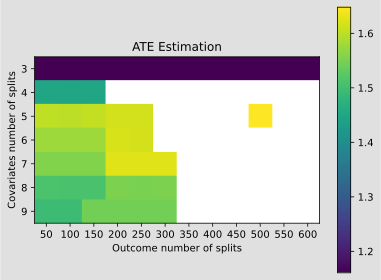

In [151]:
plt.imshow(s_grid)
plt.yticks(np.arange(len(covariate_split_list)), labels=covariate_split_list)
plt.xticks(np.arange(len(outcome_split_list)), labels=outcome_split_list)
plt.colorbar()
plt.xlabel("Outcome number of splits")
plt.ylabel("Covariates number of splits")
plt.title("ATE Estimation")

plt.show()